# Question 1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import tensorflow as tf
from keras import utils
from math import sqrt


## Data preprocessing


### Training data

In [19]:
root = Path(os.getcwd()).parents[1]
data_src = root.joinpath("data", "TrainData.csv")
test_set_input_src = root.joinpath("data", "WeatherForecastInput.csv")
solution_src = root.joinpath("data", "Solution.csv")
template_src = root.joinpath("data", "ForecastTemplate.csv")



In [4]:
# read in the data
training_set = pd.read_csv(data_src, usecols=["TIMESTAMP", "POWER", "WS10"])
training_set.head()


,TIMESTAMP,POWER,WS10
0,20120101 1:00,0.273678,3.699120
1,20120101 2:00,0.086796,2.696797
2,20120101 3:00,0.006811,2.030140
3,20120101 4:00,0.018646,1.847362
4,20120101 5:00,0.034812,1.824698


In [5]:
# split the data into X and y
X = training_set["WS10"]
y = training_set["POWER"]

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


### Testing data

In [6]:
# read test data
test_set_input = pd.read_csv(test_set_input_src, usecols=["WS10"])
test_set = test_set_input["WS10"]
test_set = test_set.values.reshape(-1, 1)
test_set.shape


(720, 1)

In [7]:
solution_set = pd.read_csv(solution_src, usecols=["POWER", "TIMESTAMP"])
solution_vector = solution_set["POWER"].values
forecast_dates = pd.to_datetime(solution_set["TIMESTAMP"], format="%Y%m%d %H:%M")


## Data plotting

In [48]:
def plot_training(predictions, model_name):
    print(
        "Root Mean Squared Error(RMSE): ",
        sqrt(mean_squared_error(solution_vector, predictions)),
    )

    # plot the data
    plt.scatter(X, y, color="black", facecolor="none", edgecolor="black", label="Training data")
    plt.scatter(test_set, predictions, color="red", label="Predictions")
    plt.title(f"Training data - {model_name}")
    plt.xlabel("Wind Speed")
    plt.ylabel("Wind Power")
    plt.legend()
    
    path = root.joinpath("fig", f"q1-{model_name}-training.png")
    plt.savefig(path, dpi=300, bbox_inches="tight")


In [51]:
def plot_forecast(predictions, model_name):
    # line plot of the predictied power for each hour
    plt.figure(figsize=(12, 6))
    plt.plot(forecast_dates, solution_vector, label="Actual Power")
    plt.plot(forecast_dates, predictions, label="Predicted Power")
    plt.title(f"Forecasted Power vs. Actual Power - {model_name}")
    plt.xticks(rotation=45)
    plt.xlabel("Time")
    plt.ylabel("Wind Power")
    plt.legend()
    plt.tight_layout()

    path = root.joinpath("fig", f"q1-{model_name}-forecast.png")
    plt.savefig(path, dpi=300, bbox_inches="tight")


## Linear regression (LR)


In [10]:
LR_model = LinearRegression()

# fit the model
LR_model.fit(X_train.values.reshape(-1, 1), y_train)

# make predictions
LR_y_pred = LR_model.predict(test_set)


Root Mean Squared Error(RMSE):  0.21650302369561153


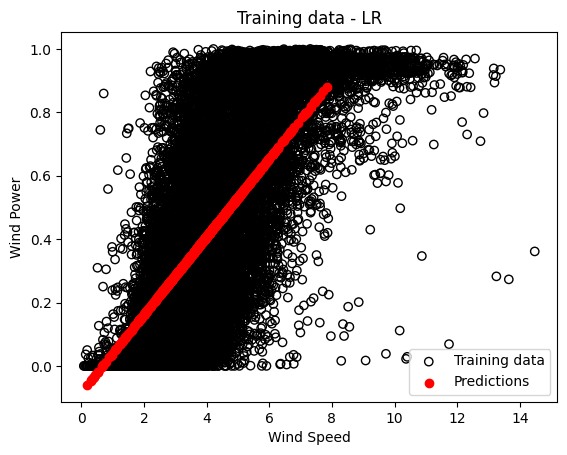

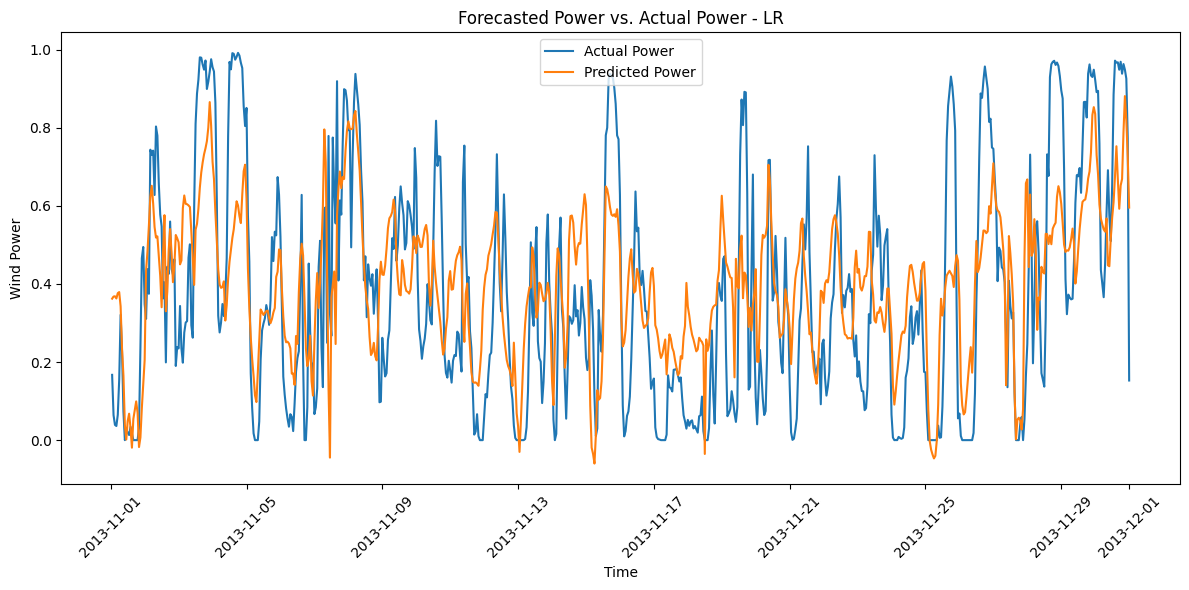

In [52]:
plot_training(LR_y_pred, "LR")
plot_forecast(LR_y_pred, "LR")


## K-nearest neighbours (kNN)

In [12]:
best_k = 0
best_rmse = float("inf")
best_knn_model = None

for k in [1, 5, 10, 100, 1000, 5000]:
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(X_train.values.reshape(-1, 1), y_train)
    knn_y_pred = knn_model.predict(test_set)
    rmse = sqrt(mean_squared_error(solution_vector, knn_y_pred))
    if rmse < best_rmse:
        best_rmse = rmse
        best_k = k
        best_knn_model = knn_model
    print(f"RMSE for k={k}: {rmse}")


# fit the model
best_knn_model.fit(X_train.values.reshape(-1, 1), y_train)

# make predictions
best_knn_y_pred = best_knn_model.predict(test_set)


RMSE for k=1: 0.3217596636187438
RMSE for k=5: 0.24404861363328942
RMSE for k=10: 0.2327243154920396
RMSE for k=100: 0.21910814763515957
RMSE for k=1000: 0.21707749962491762
RMSE for k=5000: 0.22405605496352698


Root Mean Squared Error(RMSE):  0.21707749962491762


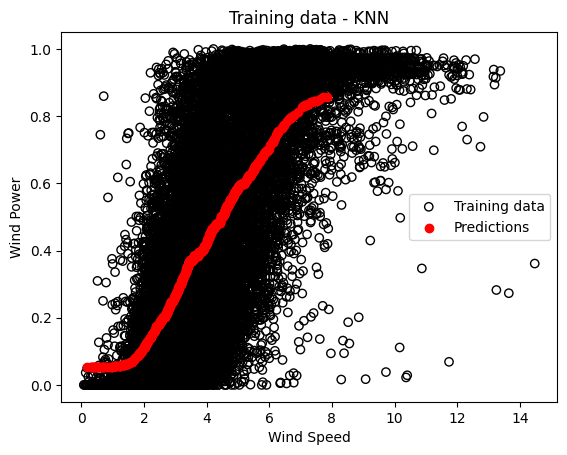

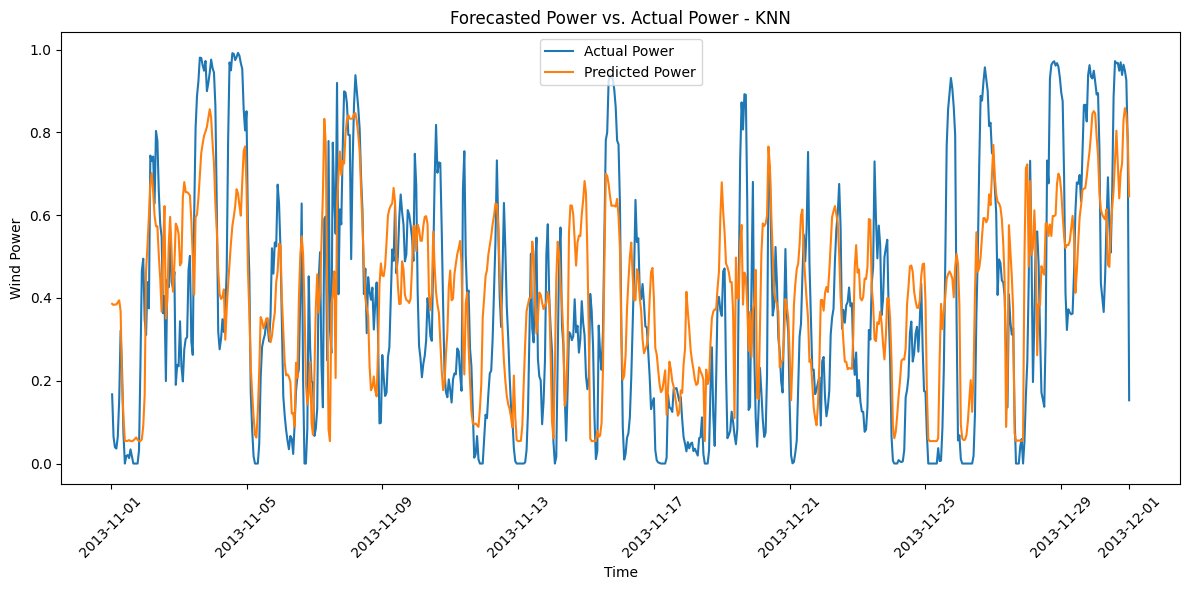

In [53]:
plot_training(best_knn_y_pred, "KNN")
plot_forecast(best_knn_y_pred, "KNN")


## Support vector regression (SVR)

In [14]:
best_step_size = 0
best_rmse = float("inf")
best_svr_model = None

for step_size in [0.01, 0.05, 0.1, 1]:
    svr_model = SVR(C=1.0, epsilon=step_size)
    svr_model.fit(X_train.values.reshape(-1, 1), y_train)
    svr_y_pred = svr_model.predict(test_set)
    rmse = sqrt(mean_squared_error(solution_vector, svr_y_pred))
    if rmse < best_rmse:
        best_rmse = rmse
        best_step_size = step_size
        best_svr_model = svr_model
    print(f"RMSE for step_size = {step_size}: {rmse}")

# fit the model
best_svr_model.fit(X_train.values.reshape(-1, 1), y_train)

# make predictions
best_svr_y_pred = best_svr_model.predict(test_set)


RMSE for step_size = 0.01: 0.2148295397172597
RMSE for step_size = 0.05: 0.21436568467631875
RMSE for step_size = 0.1: 0.21402290042440072
RMSE for step_size = 1: 0.317484122212153


Root Mean Squared Error(RMSE):  0.21402290042440072


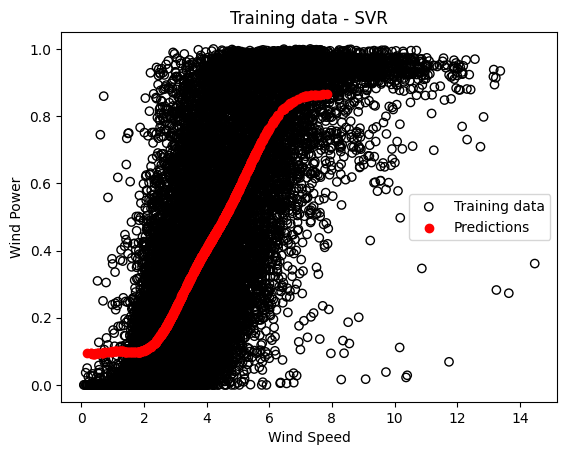

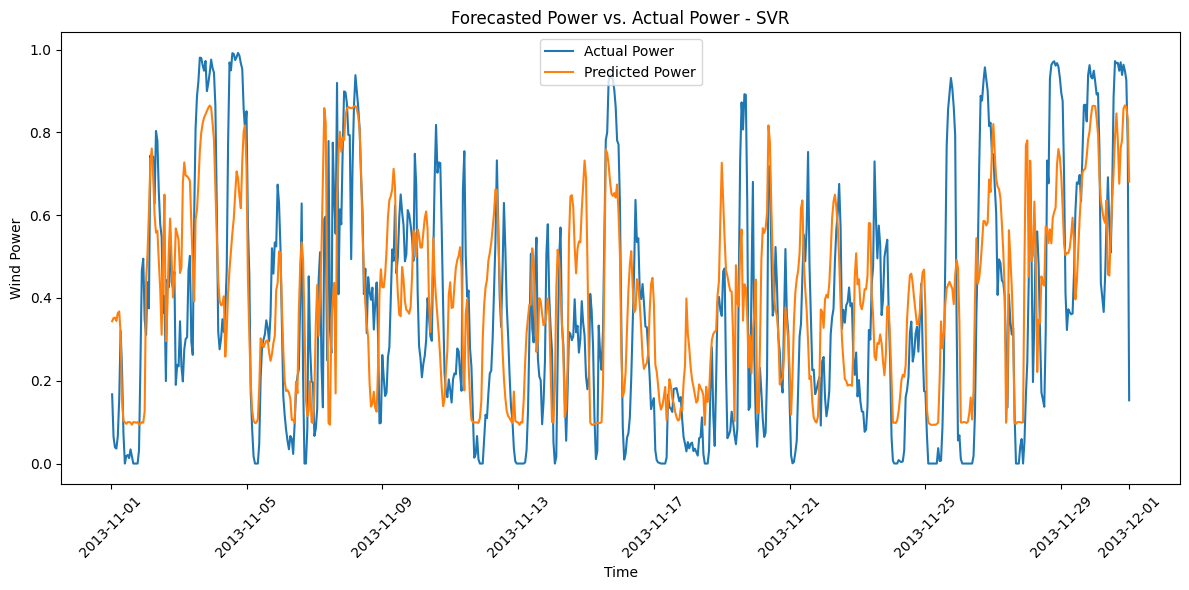

In [54]:
plot_training(best_svr_y_pred, "SVR")
plot_forecast(best_svr_y_pred, "SVR")


## Neural network (NN)

In [16]:
nn_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(64, activation="relu", input_shape=(1,)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

# Compile the model
nn_model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
nn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# make predictions
nn_y_pred = nn_model.predict(test_set)


c:\Users\eirro\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\data_adapter.py:1798: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/30
282/282 [==============================] - 3s 4ms/step - loss: 0.0601 - val_loss: 0.0529
Epoch 2/30
282/282 [==============================] - 1s 3ms/step - loss: 0.0554 - val_loss: 0.0569
Epoch 3/30
282/282 [==============================] - 1s 3ms/step - loss: 0.0567 - val_loss: 0.0531
Epoch 4/30
282/282 [==============================] - 1s 3ms/step - loss: 0.0564 - val_loss: 0.0535
Epoch 5/30
282/282 [==============================] - 1s 3ms/step - loss: 0.0552 - val_loss: 0.0528
Epoch 6/30
282/282 [==============================] - 1s 3ms/step - loss: 0.0546 - val_loss: 0.0525
Epoch 7/30
282/282 [==============================] - 1s 3ms/step - loss: 0.0539 - val_loss: 0.0523
Epoch 8/30
282/282 [==============================] - 1s 3ms/step - loss: 0.0526 - val_loss: 0.0517
Epoch 9/30
282/282 [==============================] - 1s 3ms/step - loss: 0.0522 - val_loss: 0.0526
Epoch 10/30
282/282 [==============================] - 1s 3ms/step - loss: 0.0515 - val_loss: 0.0513

Root Mean Squared Error(RMSE):  0.21583548910597064


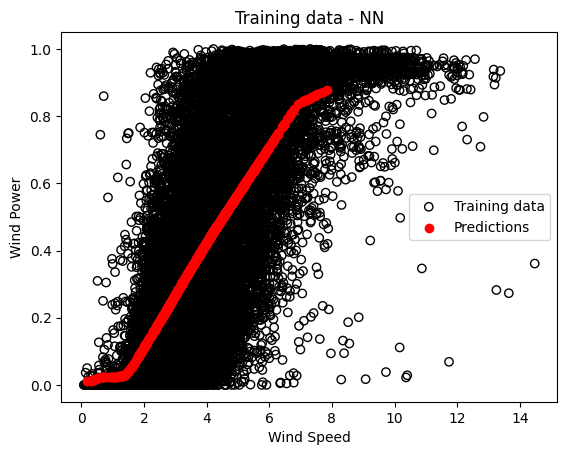

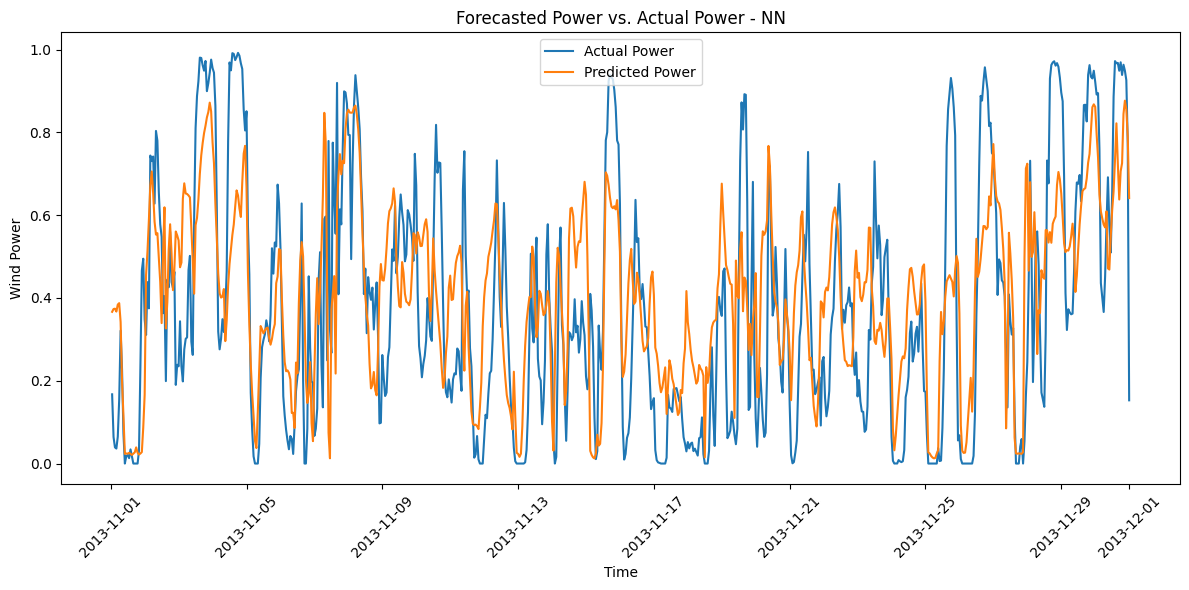

In [55]:
plot_training(nn_y_pred, "NN")
plot_forecast(nn_y_pred, "NN")


## Write forecasts to file

In [22]:
predictions = pd.DataFrame(
    {
        "LR": LR_y_pred.flatten(),
        "KNN": best_knn_y_pred.flatten(),
        "SVR": best_svr_y_pred.flatten(),
        "NN": nn_y_pred.flatten(),
    }
)

for model in predictions.columns:
    template = pd.read_csv(template_src)
    template["FORECAST"] = predictions[model]
    template.to_csv(f"export/ForecastTemplate1-{model}.csv", index=False)

print("Root Mean Squared Error(RMSE):")
for model in predictions.columns:
    print(f"{model}", sqrt(mean_squared_error(solution_vector, predictions[model])))


Root Mean Squared Error(RMSE):
LR 0.21650302369561153
KNN 0.21707749962491762
SVR 0.21402290042440072
NN 0.21583548910597064
